# Community Detection with Amazon Braket Hybrid Jobs

In this tutorial, we use Amazon Braket Hybrid Jobs to run D-Wave QBSolv for a Community Detection problem.

For more background on community detection using quantum annealing, please refer to the introduction notebook ([Notebook_QBSolv_community_detection.ipynb](https://github.com/aws-samples/amazon-braket-community-detection/blob/main/Notebook_QBSolv_community_detection.ipynb)). 

## Table of contents
* [Set Up Environment](#Set_Up_Environment)
* [Prepare Input Data](#inputdata)
    * [Built-in Graph](#Built-in_Graph)
    * [Graph from a Local Data File](#local_graph)
* [Create Algorithm Script](#algorithm_script)
* [Specify Hyperparameters](#hyperparameters)
* [Submit a Braket Hybrid Job](#submit_braket_job)
* [View Results](#view_results)
* [Run Hyperparameter Tuning](#hpo)

## Set Up Environment <a name="Set_Up_Environment"></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
import time
import ast
import json
import collections
import networkx as nx

from braket.jobs.config import InstanceConfig
from braket.jobs.local.local_job import LocalQuantumJob
from braket.aws import AwsQuantumJob

from src.graph_community import CommunityGraphFactory, draw_graph_community

## Prepare Input Data <a name="inputdata"></a>

To prepare the input graph data, the first step is to run the '**Download Graph Data**' part in the [Notebook_QBSolv_community_detection.ipynb](https://github.com/aws-samples/amazon-braket-community-detection/blob/main/Notebook_QBSolv_community_detection.ipynb) that downloads real-world graphs from http://networkrepository.com and cleanses raw graph data files. Then we call `CommunityGraphFactory` to read and visualize a graph, and save it as a NetworkX graph. 

In [2]:
# call CommunityGraphFactory for graph data preparation
cgf = CommunityGraphFactory(seed=1)

In order to load a graph from local data files via a name, we create a dictionary `graph_file_dict` with graph names, their local file path, and the delimiter used in the file. 
`graph_file_dict` is required to have this format: {graph_name: [data_path, delimiter]}

In [3]:
graph_file_dict = {"Jazz": ["./data/Jazz/arenas-jazz.edges", ","], 
                   "Dolphins": ["./data/Dolphins/dolphins.mtx", None],
                   "LesMiserables": ["./data/LesMiserables/lesmis.mtx",None],
                   "Elegans": ["./data/Elegans/celegans_metabolic.mtx", None],
                   "Emailuniv": ["./data/Emailuniv/ia-email-univ.mtx", None],
                   "Cora": ["./data/Cora/cora.edges", ","]}

### Built-in Graph <a name="Built-in_Graph"></a>

This code example shows how to create the Zachary's karate club graph using NetworkX's built-in graph function, save the graph to a local file in NetworkX Graph format as input data for Braket jobs.

In [4]:
# Create a input graph folder to store files
if not os.path.exists("data/input_graph"):
    os.makedirs("data/input_graph")

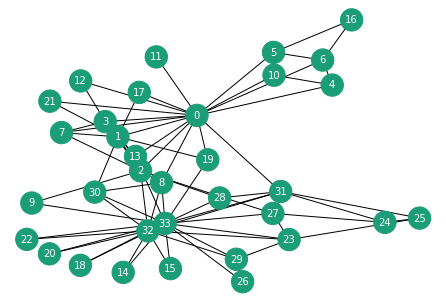

In [5]:
# using networkx graph
graph_name = "Zachary"
graph_zachary = nx.karate_club_graph()

# save the graph to a local file using NetworkX
nx.write_weighted_edgelist(graph_zachary, f"data/input_graph/{graph_name}.weighted.edgelist")

# draw a graph
draw_graph_community(graph_zachary, [list(range(graph_zachary.number_of_nodes()))], color_map = 'Dark2')
plt.show()

### Graph from a Local Data File <a name="local_graph"></a>
This code example shows how to create a graph through loading a local data file listed in `graph_file_dict`, and save it to another local file in NetworkX Graph format as input data for Braket jobs.

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 159
Average degree:   5.1290


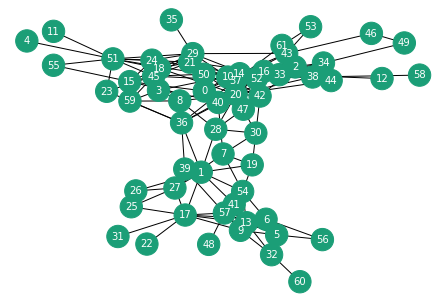

In [6]:
# load a graph from local files defined in 'graph_file_dict'
graph_name = "Dolphins"
graph_data = cgf.load_graph(graph_name, graph_file_dict)

# save the graph to a local file using NetworkX
nx.write_weighted_edgelist(graph_data, f"data/input_graph/{graph_name}.weighted.edgelist")

# draw a graph
draw_graph_community(graph_data, [list(range(graph_data.number_of_nodes()))], color_map = 'Dark2')
plt.show()

## Create Algorithm Script <a name="algorithm_script"></a>

The algorithm script we are going to use for solving the Community Detection problem using QBSolv can be found [here](src/hybrid_job_community_detection.py) (`src/hybrid_job_community_detection.py`).

## Specify Hyperparameters <a name="hyperparameters"></a>

The hyperparameters can be passed to our algorithm script (`src/hybrid_job_community_detection.py`) when you create your job, through the keyword argument <code>hyperparameters</code>. It usually includes all the algorithm settings you might want to adjust between runs to tailor your algorithm to the problem.

In [7]:
# specify an input graph file and its local path
graph_name = "Zachary"
input_graph_file_name = "Zachary.weighted.edgelist"
input_graph_path = os.path.join("data/input_graph", input_graph_file_name)

# specify hyperparameters for the algorithm script 
hyperparams = {
    "input_graph_file": input_graph_file_name, # str, the file name of the input graph
    "num_community": 4, # int, the number of communities to detect
    "solver_mode": "hybrid", # str, must be either 'classical' or 'hybrid'. Determines whether the classical or hybrid solver is called
    "solver_limit": 100, # int, the maximum number of variables (n) for sub-QUBOs
    "num_repeats": 2, # int, the maximum iterations to repeat QBSolv solver execution to discover a new best solution
    "num_reads": 1000, # int, how many times the annealing is performed
    "seed": 1, # int, random seed
    "alpha": 5, # int, the penalty coefficient to enforce assigning only one community to each node
    }

# JSON encode hyperparameters as required by Amazon Braket jobs 
hyperparams = {str(k): json.dumps(v) for (k, v) in hyperparams.items()}
print(f"JSON encoded hyperparameters:\n{hyperparams}")

JSON encoded hyperparameters:
{'input_graph_file': '"Zachary.weighted.edgelist"', 'num_community': '4', 'solver_mode': '"hybrid"', 'solver_limit': '100', 'num_repeats': '2', 'num_reads': '1000', 'seed': '1', 'alpha': '5'}


## Submit a Braket Job <a name="submit_braket_job"></a>

We have now finished preparing the input data, algorithm script, hyperparameters and other configurations. It's time to submit our Braket Job!

Similar to this [Braket example notebook](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_jobs/2_Using_PennyLane_with_Braket_Jobs), we specify the following arguments to create our job: 

- <code>device</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>instance_config</code>: The configuration of classical resource such as instance type and data storage volume to run the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values (as strings).
- <code>input_data</code>: A dictionary that maps channel names to either a file location in the local environment or a path to S3. We can also specify only a file location, in which case the channel name is treated as "input".
- <code>wait_until_complete</code>: If True, the function call will wait until the Braket Job is completed, and will additionally print logs to the local console. Otherwise, it will run asynchronously. Defaults to False.

**QPU cost warning**: QBSolv hybrid solver will cause addtional cost for using D-Wave QPU. Please evaluate potential cost before executing QBSolv hybrid job

In [8]:
# specify device that the job will primarily be targeting
device_arn = 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4' # D-Wave QPU Device ARN

# submit a Braket job
aws_job = AwsQuantumJob.create(
    device=device_arn,
    instance_config=InstanceConfig(instanceType="ml.m5.xlarge"),
    source_module="src",
    job_name="Job-"+graph_name+"-" + str(int(time.time())),
    entry_point="src.hybrid_job_community_detection",
    hyperparameters=hyperparams,
    input_data={"input-graph": input_graph_path},
    wait_until_complete = False
)

The status of a Braket Job can be checked by calling `job.state()`. The state will be one of "QUEUED", "RUNNING", "FAILED", "COMPLETED", "CANCELLING", or "CANCELLED"

In [17]:
print(aws_job.state())

COMPLETED


## View Results <a name="view_results"></a>

After the job is completed, we can view the results saved by the algorithm script.

Result may vary between different job runs, especially for QBSolv hybrid solver jobs. You may want to increase the `num_repeats` value to get better results.

In [18]:
# view job results
print(aws_job.result())

{'community_results': "{'modularity': 0.41978961209730437, 'num_comm': 4, 'comm': [{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {4, 5, 6, 10, 16}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}, {23, 24, 25, 27, 28, 31}]}", 'hyperparams': '{\'num_community\': \'4\', \'seed\': \'1\', \'input_graph_file\': \'"Zachary.weighted.edgelist"\', \'solver_limit\': \'100\', \'solver_mode\': \'"hybrid"\', \'alpha\': \'5\', \'num_reads\': \'1000\', \'num_repeats\': \'2\'}', 'qbsolv_output': "   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 135    energy num_oc.\n0  1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   0  -5.41979       1\n1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0  -5.41979       1\n2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -5.418803       3\n3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...   0 -5.417242       1\n4  1  1  1  1  0  0  0  1  0  1  0  1  1  1  0  0  0 ...   0 -5.417242       1\n5  0  0  0  0  0  0  0  0  0  0  0  0  0

In [19]:
# retrieve results for community assingments
community_results = ast.literal_eval(aws_job.result()['community_results'])
print(community_results)

{'modularity': 0.41978961209730437, 'num_comm': 4, 'comm': [{0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}, {4, 5, 6, 10, 16}, {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}, {23, 24, 25, 27, 28, 31}]}


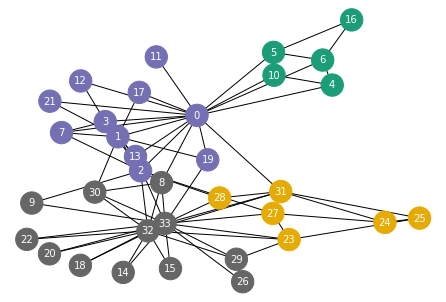

In [20]:
# read the input graph file for plotting
#nx_G = nx.read_weighted_edgelist(input_graph_path)

# or use built-in graph
nx_G = nx.karate_club_graph()

# We draw a graph colored with communities
draw_graph_community(nx_G, list(community_results['comm']), color_map = 'Dark2')
plt.show()

## Run Hyperparameter Tuning <a name="hpo"></a>

Similar to this [Braket example notebook on hyperparameter tuning](https://github.com/aws/amazon-braket-examples/tree/main/examples/hybrid_jobs/1_Hyperparameter_tuning), we use Braket jobs to submit and monitor many jobs simultaneously that have different hyperparameter settings. Here, we show an example to find the optimal number of communities for a given graph by scanning different numbers of communities to detect and comparing their modularity values. 

In [24]:
jobs = []
names = []

for num_community in range(2, 6):
    print(f"Creating job with {num_community} communities")
    name = f"hyper-param-job-{graph_name}-{num_community}-" + str(int(time.time()))
    
    hyperparams = {
    "input_graph_file": input_graph_file_name, 
    "num_community": num_community,
    "solver_mode": "hybrid", 
    "solver_limit": 100, 
    "num_repeats": 2, 
    "num_reads": 1000, 
    "seed": 1, 
    "alpha": 5, 
    }

    # JSON encode hyperparameters as required by Amazon Braket jobs 
    hyperparams = {str(k): json.dumps(v) for (k, v) in hyperparams.items()}
    
    # submit a Braket job
    tmp_job = AwsQuantumJob.create(
        device=device_arn,
        instance_config=InstanceConfig(instanceType="ml.m5.xlarge"),
        source_module="src",
        job_name=name,
        entry_point="src.hybrid_job_community_detection",
        hyperparameters=hyperparams,
        input_data={"input-graph": input_graph_path},
        wait_until_complete = False
    )
    jobs.append(tmp_job)
    names.append(name)

Creating job with 2 communities
Creating job with 3 communities
Creating job with 4 communities
Creating job with 5 communities


To monitor the job status in real time, you can access its Amazon CloudWatch Logs under the ‘Jobs’ tab in the Amazon Braket console. Because D-Wave QPUs are only available in the AWS ‘us-west-2’ Region, you will need to set the AWS Management Console Region to `us-west-2` in order to see the status of your jobs.
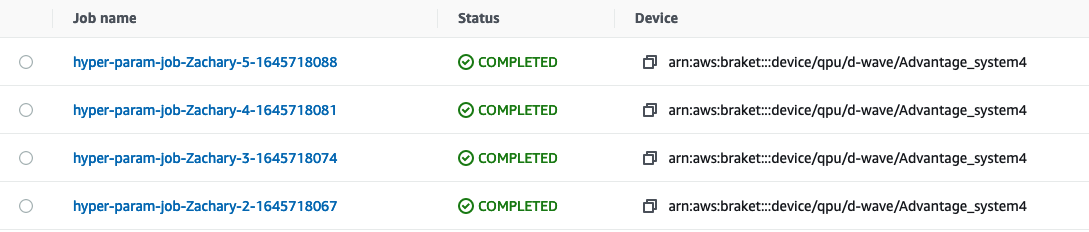

In [25]:
jobs[-1].result() # check results for one of the jobs

{'community_results': "{'modularity': 0.41880341880341876, 'num_comm': 4, 'comm': [{0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 26, 29, 30}, {23, 24, 25, 27, 28, 31}]}",
 'hyperparams': '{\'num_community\': \'5\', \'seed\': \'1\', \'input_graph_file\': \'"Zachary.weighted.edgelist"\', \'solver_limit\': \'100\', \'solver_mode\': \'"hybrid"\', \'alpha\': \'5\', \'num_reads\': \'1000\', \'num_repeats\': \'2\'}',
 'qbsolv_output': "   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 169    energy num_oc.\n0  1  1  1  1  0  0  0  1  0  1  0  1  1  1  0  0  0 ...   0 -5.418803       1\n1  1  1  1  1  0  0  0  1  0  1  0  1  1  1  0  0  0 ...   0 -5.417242       2\n2  1  1  1  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   0 -5.411654       1\n3  1  1  0  1  0  0  0  1  0  0  0  1  1  1  0  0  0 ...   0 -5.409352       2\n4  1  1  1  1  0  0  0  1  0  0  0  0  1  1  0  0  0 ...   0 -5.403764       1\n5  1  1  1  1  0  0  0  1  0  0  0  0 

We can now check the results from all the experiments once they finish.

In [26]:
results_dict = collections.defaultdict(list)

for job in jobs:
    results_dict['Number of communities'].append(int(ast.literal_eval(job.result()['hyperparams'])['num_community']))
    results_dict['Modularity'].append(ast.literal_eval(job.result()['community_results'])['modularity'])
    
df = pd.DataFrame.from_dict(results_dict)

In [27]:
df

,Number of communities,Modularity
0,2,0.371795
1,3,0.402038
2,4,0.419790
3,5,0.418803


From the result table above, we can see 4 is the optimal number of communities for the Zachary karate club network because it is the smallest number of communities to achieve the highest modularity value.